# Quick Start Examples - Hierarchical Retail Data

In [6]:
%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:

import numpy as np
import pandas as pd
import os 
import seaborn as sns
from matplotlib import style
sns.set_context("notebook", font_scale=1.25)
style.use('fivethirtyeight')


def assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols, target='sales'):
    data = data.copy(deep=True)
    data['hierarchy'] = [hierarchy_tuple]*len(data)
    data[hierarchy_cols] = pd.DataFrame(data['hierarchy'].tolist(), index=data.index)
    data.drop('hierarchy', axis=1, inplace=True)

    data.rename({"y":"sales", "ds":"datetime"}, axis=1, inplace=True)
    data[target] = data[target] + np.random.normal(0, data[target].std()*.2, len(data))
    data.loc[data[target] < 0, target] = 0
    data[target] = data[target].astype(int)

    # change column order
    data = data[['datetime'] + hierarchy_cols + [target]]

    return data

# help ipython find our path
directory = os.path.dirname(os.path.abspath(''))
os.chdir(directory)

import forecastframe as ff


In [8]:
# hierarchical_data = pd.read_csv("./forecastframe/sample_data/daily/small.csv") # decided to create fake data instead of using this messy hierarchical data from kaggle

data = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv")

In [9]:
# create fake hierarchical retail dataset
hierarchy_cols = ['state', 'store_id', 'category', 'sku']

stores_per_state = 1
states = ('CO', 'TX', 'CA')

categories = ('FOOD', 'APPAREL')
skus_per_dept = 2

fake_hierarchy = tuple(((state, f"{state}_{store_id}", cat, f"{cat}_{sku}") for cat in categories for sku in range(skus_per_dept) for state in states for store_id in range(stores_per_state)))

df = pd.concat([assign_fake_hierarchy(data, hierarchy_tuple, hierarchy_cols=hierarchy_cols) for hierarchy_tuple in fake_hierarchy])
#df.to_csv('./forecastframe/sample_data/daily/mock_hierarchical_retail_sales.csv', index=False)

In [10]:
fframe = ff.ForecastFrame(data=df, target="sales", datetime_column="datetime", hierarchy=hierarchy_cols)

### Prophet

In [11]:
fframe.predict(model="prophet", future_periods=10, weekly_seasonality=True, daily_seasonality=True)
predictions = fframe.get_predictions(append_hierarchy_col=True)

Importing plotly failed. Interactive plots will not work.


Initial log joint probability = -16.4398
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9857.45    0.00487611       1105.76           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9925.21     0.0057068       3889.66        0.15           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        9963.3     0.0021825        853.17      0.3331      0.3331      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9969.68    0.00263721       398.781           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       9976.29   7.68442e-05       440.468    3.43e-07       0.001      555  LS failed, Hessian reset 
     499       9979.16    0.00023158    

In [7]:
fframe.cross_validate(folds=3, model="prophet")

Initial log joint probability = -8.53696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       2084.23   0.000204475       121.083   9.775e-07       0.001      164  LS failed, Hessian reset 
      99        2084.3    0.00105696        83.037           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       2084.49   8.79199e-05       84.9265   7.834e-07       0.001      330  LS failed, Hessian reset 
     199        2084.5   5.82499e-05        87.757           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2084.51   4.81911e-08       83.4795      0.3694           1      404   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.53696
    Iter      log prob        ||dx||      ||grad||   

In [8]:
# check that the latest round of predictions stored in the object were created using the params found in cross-validation
assert fframe.model_object.seasonality_mode == fframe.cross_validations[-1]["best_params"]["seasonality_mode"]

In [9]:
fframe.get_cross_validation_errors()

[{'In-Sample':              Actuals    Predictions  Absolute Percent Error  Absolute Error  \
  count     879.000000     879.000000              879.000000      879.000000   
  mean   197969.791809  197963.225132                0.070754    13487.951310   
  std     31345.215615   26412.251678                0.057578    10147.058942   
  min    110581.000000  145442.921674                0.000140       27.400547   
  25%    174855.000000  180790.841514                0.027707     5551.644021   
  50%    198226.000000  197489.347642                0.056607    10923.641668   
  75%    220248.000000  218744.004998                0.098537    19551.131331   
  max    298219.000000  274866.509780                0.356235    49093.895414   
  
         Squared Error  
  count   8.790000e+02  
  mean    2.847705e+08  
  std     3.906134e+08  
  min     7.507900e+02  
  25%     3.082082e+07  
  50%     1.193259e+08  
  75%     3.822476e+08  
  max     2.410211e+09  ,
  'Out-of-Sample':           

In [10]:
fframe.save_fframe(name='prophet.pkl')

Saving to /home/nthor/forecastframe/prophet.pkl...


### LightGBM

<AxesSubplot:xlabel='datetime'>

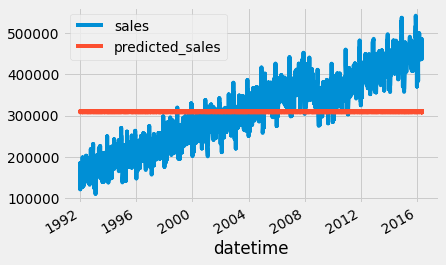

In [11]:
# Predictions are weak because our model doesn't have any features to grip on
# Note we can pass in lightgbm params as kwargs, such as learning_rate
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [12]:
# Let's add some features to help our model out
#fframe.calc_datetime_features()
fframe.lag_features(features=[fframe.target], lags=[1, 2, 3, 12]) # lagged features for 1 month ago, 2 months ago ..., 12 months ago
fframe.calc_statistical_features(features=[fframe.target], windows=[3, 6, 12], aggregations=['mean', 'std']) # 3, 6, and 12 month rolling aggregations for both mean and std
fframe.calc_ewma(fframe.target, windows=[3, 6, 12]) # 3, 6, 12 month exponential weighted moving averages

fframe.get_sample()

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


,state,store_id,category,sku,sales,sales_lag1,sales_lag2,sales_lag3,sales_lag12,sales_mean_roll3_lag1,sales_std_roll3_lag1,sales_mean_roll6_lag1,sales_std_roll6_lag1,sales_mean_roll12_lag1,sales_std_roll12_lag1,sales_ewma_roll3_lag1,sales_ewma_roll6_lag1,sales_ewma_roll12_lag1
datetime,,,,,,,,,,,,,,,,,,
1992-01-01,1,1,0,0,144687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-01,1,1,0,0,148178,144687.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-03-01,1,1,0,0,168351,148178.0,144687.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-04-01,1,1,0,0,160515,168351.0,148178.0,144687.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159206.714286,NaN,NaN
1992-05-01,1,1,0,0,168329,160515.0,168351.0,148178.0,NaN,153873.0,NaN,153873.0,NaN,153873.0,NaN,159904.466667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-09-01,1,1,0,1,265175,279016.0,320318.0,286297.0,287957.0,465507.0,NaN,465507.0,NaN,465507.0,NaN,290661.612399,289456.029040,285903.473290
2001-10-01,1,1,0,1,285650,265175.0,279016.0,320318.0,289918.0,465045.0,NaN,465045.0,NaN,465045.0,NaN,277918.306200,282518.592172,282714.477389
2001-11-01,1,1,0,1,289793,285650.0,265175.0,279016.0,290286.0,480982.0,NaN,480982.0,NaN,480982.0,NaN,281784.153100,283413.280123,283166.096253


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


<AxesSubplot:xlabel='datetime'>

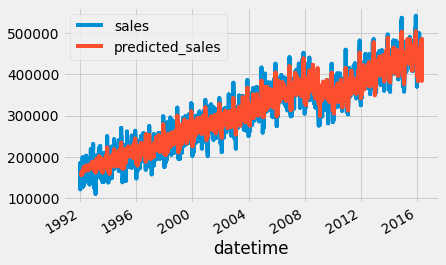

In [13]:
fframe.predict(model="lightgbm", future_periods=10, learning_rate=.04)
fframe.get_predictions().plot.line()

In [14]:
fframe.get_errors()

,Actuals,Predictions,Absolute Percent Error,Absolute Error,Squared Error
count,879.000000,879.000000,879.000000,879.000000,8.790000e+02
mean,411985.036405,325409.032476,0.204536,87103.644605,9.486043e+09
std,41859.557242,25081.844329,0.091089,43602.309590,7.688799e+09
min,303108.000000,272603.603062,0.000138,48.864402,2.387730e+03
25%,381238.500000,307904.878161,0.137427,53905.347890,2.905821e+09
50%,411007.000000,325683.897689,0.216944,88131.102311,7.767091e+09
75%,442619.000000,340768.888861,0.279182,122429.275304,1.498893e+10
max,542116.000000,398009.229502,0.383387,187570.908221,3.518285e+10


In [15]:
fframe.cross_validate(folds=3, model="lightgbm")

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


Running fold 1 of 3 with train shape (879, 18) and test shape (879, 18)


Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


Running fold 2 of 3 with train shape (1758, 18) and test shape (879, 18)


KeyboardInterrupt: 

In [ ]:
fframe.save_fframe(name='lightgbm.pkl')

Saving to /home/nthor/forecastframe/forecastframe.pkl
